# TabNet for fastai

> This is an adaptation of TabNet (Attention-based network for tabular data) for fastai (>=2.0) library. The original paper https://arxiv.org/pdf/1908.07442.pdf. 
> The Pytorch implementation is made by dreamquark-ai team https://github.com/dreamquark-ai/tabnet
> Special thanks to Dmitry Grankin (@DmitriyG228) and Zachary Muller (@muellerzr) for their help in composing the repo.

## Install

`pip install fast_tabnet`

## How to use

`model = TabNetModel(emb_szs, n_cont, out_sz, embed_p=0., y_range=None, 
                     n_d=8, n_a=8,
                     n_steps=3, gamma=1.5, 
                     n_independent=2, n_shared=2, epsilon=1e-15,
                     virtual_batch_size=128, momentum=0.02)`

Parameters `emb_szs, n_cont, out_sz, embed_p, y_range` are the same as for fastai TabularModel.

- n_d : int
    Dimension of the prediction  layer (usually between 4 and 64)
- n_a : int
    Dimension of the attention  layer (usually between 4 and 64)
- n_steps: int
    Number of sucessive steps in the newtork (usually betwenn 3 and 10)
- gamma : float
    Float above 1, scaling factor for attention updates (usually betwenn 1.0 to 2.0)
- momentum : float
    Float value between 0 and 1 which will be used for momentum in all batch norm
- n_independent : int
    Number of independent GLU layer in each GLU block (default 2)
- n_shared : int
    Number of independent GLU layer in each GLU block (default 2)
- epsilon: float
    Avoid log(0), this should be kept very low


## Example

Below is an example from fastai library, but the model in use is TabNet

In [ ]:
from fastai.basics import *
from fastai.tabular.all import *
from fast_tabnet.core import *

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')
df_main,df_test = df.iloc[:-1000].copy(),df.iloc[-1000:].copy()
df_main.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [ ]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 
             'relationship', 'race', 'native-country', 'sex']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter()(range_of(df_main))

In [ ]:
to = TabularPandas(df_main, procs, cat_names, cont_names, y_names="salary", 
                   y_block = CategoryBlock(), splits=splits)

In [ ]:
dls = to.dataloaders(bs=32)

In [ ]:
dls.valid.show_batch()

,workclass,education,marital-status,occupation,relationship,race,native-country,sex,education-num_na,age,fnlwgt,education-num,salary
0,Private,HS-grad,Married-civ-spouse,Other-service,Wife,White,United-States,Female,False,39.000000,196673.000115,9.0,<50k
1,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,United-States,Male,False,32.000000,198067.999771,9.0,<50k
2,State-gov,HS-grad,Never-married,Adm-clerical,Own-child,White,United-States,Female,False,18.999999,176633.999931,9.0,<50k
3,Private,Some-college,Married-civ-spouse,Prof-specialty,Husband,White,United-States,Male,False,67.999999,107626.998490,10.0,<50k
4,Private,Masters,Never-married,Exec-managerial,Not-in-family,Black,United-States,Male,False,29.000000,214925.000260,14.0,<50k
5,Private,HS-grad,Married-civ-spouse,Priv-house-serv,Wife,White,United-States,Female,False,22.000000,200109.000126,9.0,<50k
6,Private,Some-college,Never-married,Sales,Own-child,White,United-States,Female,False,18.000000,60980.998429,10.0,<50k
7,Private,Some-college,Separated,Adm-clerical,Not-in-family,White,United-States,Female,False,28.000000,334367.998199,10.0,<50k
8,Private,11th,Married-civ-spouse,Transport-moving,Husband,White,United-States,Male,False,49.000000,123584.001097,7.0,<50k
9,Private,Masters,Never-married,Prof-specialty,Not-in-family,White,United-States,Female,False,26.000000,397316.999922,14.0,<50k


In [ ]:
to_tst = to.new(df_test)
to_tst.process()
to_tst.all_cols.head()

,workclass,education,marital-status,occupation,relationship,race,native-country,sex,education-num_na,age,fnlwgt,education-num,salary
31561,5,2,5,9,3,3,40,2,1,-1.505833,-0.559418,-1.202170,0
31562,2,12,5,2,5,3,40,1,1,-1.432653,0.421241,-0.418032,0
31563,5,7,3,4,1,5,40,2,1,-0.115406,0.132868,-1.986307,0
31564,8,12,3,9,1,5,40,2,1,1.494561,0.749805,-0.418032,0
31565,1,12,1,1,5,3,40,2,1,-0.481308,7.529798,-0.418032,0


In [ ]:
emb_szs = get_emb_sz(to)

That's the use of the model

In [ ]:
model = TabNetModel(emb_szs, len(to.cont_names), dls.c, n_d=8, n_a=8, n_steps=5, mask_type='entmax');

In [ ]:
learn = Learner(dls, model, CrossEntropyLossFlat(), opt_func=Adam, lr=3e-2, metrics=[accuracy])

SuggestedLRs(lr_min=0.2754228591918945, lr_steep=1.9054607491852948e-06)

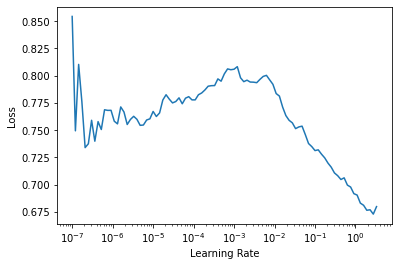

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.446274,0.414451,0.817015,00:30
1,0.380002,0.393030,0.818916,00:30
2,0.371149,0.359802,0.832066,00:30
3,0.349027,0.352255,0.835868,00:30
4,0.355339,0.349360,0.836819,00:30


## Tabnet interpretability

In [ ]:
# feature importance for 2k rows
dl = learn.dls.test_dl(df.iloc[:2000], bs=256)
feature_importances = tabnet_feature_importances(learn.model, dl)

In [ ]:
# per sample interpretation
dl = learn.dls.test_dl(df.iloc[:20], bs=20)
res_explain, res_masks = tabnet_explain(learn.model, dl)

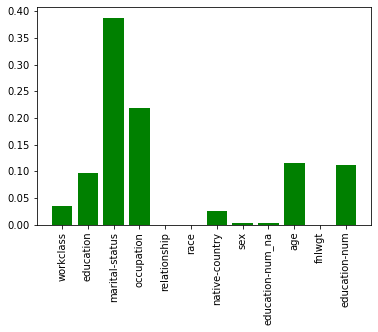

In [ ]:
plt.xticks(rotation='vertical')
plt.bar(dl.x_names, feature_importances, color='g')
plt.show()

In [ ]:
def plot_explain(masks, lbls, figsize=(12,12)):
    "Plots masks with `lbls` (`dls.x_names`)"
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    plt.yticks(np.arange(0, len(masks), 1.0))
    plt.xticks(np.arange(0, len(masks[0]), 1.0))
    ax.set_xticklabels(lbls, rotation=90)
    plt.ylabel('Sample Number')
    plt.xlabel('Variable')
    plt.imshow(masks)

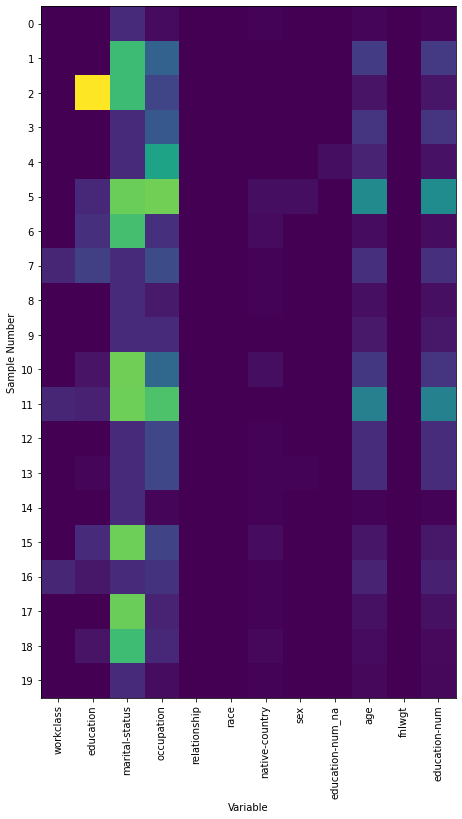

In [ ]:
plot_explain(res_explain, dl.x_names)

## Hyperparameter search with Bayesian Optimization

If your dataset isn't huge you can tune hyperparameters for tabular models with Bayesian Optimization. You can optimize directly your metric using this approach if the metric is sensitive enough (in our example it is not and we use validation loss instead). Also, you should create the second validation set, because you will use the first as a training set for Bayesian Optimization. 


You may need to install the optimizer `pip install bayesian-optimization`

In [ ]:
from functools import lru_cache

In [ ]:
# The function we'll optimize
@lru_cache(1000)
def get_accuracy(n_d:Int, n_a:Int, n_steps:Int):
    model = TabNetModel(emb_szs, len(to.cont_names), dls.c, n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=1.5)
    learn = Learner(dls, model, CrossEntropyLossFlat(), opt_func=opt_func, lr=3e-2, metrics=[accuracy])
    learn.fit_one_cycle(5)
    return float(learn.validate(dl=learn.dls.valid)[1])

This implementation of Bayesian Optimization doesn't work naturally with descreet values. That's why we use wrapper with `lru_cache`.

In [ ]:
def fit_accuracy(pow_n_d, pow_n_a, pow_n_steps):
    n_d, n_a, n_steps = map(lambda x: 2**int(x), (pow_n_d, pow_n_a, pow_n_steps))
    return get_accuracy(n_d, n_a, n_steps)

In [ ]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'pow_n_d': (0, 8), 'pow_n_a': (0, 8), 'pow_n_steps': (0, 4)}

optimizer = BayesianOptimization(
    f=fit_accuracy,
    pbounds=pbounds,
)

In [ ]:
optimizer.maximize(
    init_points=15,
    n_iter=100,
)

|   iter    |  target   |  pow_n_a  |  pow_n_d  | pow_n_... |
-------------------------------------------------------------


epoch,train_loss,valid_loss,accuracy,time
0,0.404888,0.432834,0.793885,00:10
1,0.367979,0.384840,0.818600,00:09
2,0.366444,0.372005,0.819708,00:09
3,0.362771,0.366949,0.823511,00:10
4,0.353682,0.367132,0.823511,00:10


|  1        |  0.8235   |  0.9408   |  1.898    |  1.652    |


epoch,train_loss,valid_loss,accuracy,time
0,0.393301,0.449742,0.810836,00:08
1,0.379140,0.413773,0.815589,00:07
2,0.355790,0.388907,0.822560,00:07
3,0.349984,0.362671,0.828739,00:07
4,0.348000,0.360150,0.827313,00:07


|  2        |  0.8273   |  4.262    |  5.604    |  0.2437   |


epoch,train_loss,valid_loss,accuracy,time
0,0.451572,0.434189,0.781210,00:12
1,0.423763,0.413420,0.805450,00:12
2,0.398922,0.408688,0.814164,00:12
3,0.390981,0.392398,0.808935,00:12
4,0.376418,0.382250,0.817174,00:12


|  3        |  0.8172   |  7.233    |  6.471    |  2.508    |


epoch,train_loss,valid_loss,accuracy,time
0,0.403187,0.413986,0.798162,00:07
1,0.398544,0.390102,0.820184,00:07
2,0.390569,0.389703,0.825253,00:07
3,0.375426,0.385706,0.826996,00:07
4,0.370446,0.383366,0.831115,00:06


|  4        |  0.8311   |  5.935    |  1.241    |  0.3809   |


epoch,train_loss,valid_loss,accuracy,time
0,0.464145,0.458641,0.751267,00:18
1,0.424691,0.436968,0.788023,00:18
2,0.431576,0.436581,0.775824,00:18
3,0.432143,0.437062,0.759506,00:18
4,0.429915,0.438332,0.758555,00:18


|  5        |  0.7586   |  2.554    |  0.4992   |  3.111    |


epoch,train_loss,valid_loss,accuracy,time
0,0.470359,0.475826,0.748891,00:12
1,0.411564,0.409433,0.797053,00:12
2,0.392718,0.397363,0.809727,00:12
3,0.387564,0.380033,0.814322,00:12
4,0.374153,0.378258,0.818916,00:12


|  6        |  0.8189   |  4.592    |  2.138    |  2.824    |


epoch,train_loss,valid_loss,accuracy,time
0,0.547042,0.588752,0.754119,00:18
1,0.491731,0.469795,0.771863,00:18
2,0.454340,0.433961,0.775190,00:18
3,0.424386,0.432385,0.782953,00:18
4,0.397645,0.406420,0.805767,00:19


|  7        |  0.8058   |  6.186    |  7.016    |  3.316    |


epoch,train_loss,valid_loss,accuracy,time
0,0.485245,0.487635,0.751109,00:18
1,0.450832,0.446423,0.750317,00:18
2,0.448203,0.449419,0.755228,00:18
3,0.430258,0.443562,0.744297,00:18
4,0.429821,0.437173,0.761565,00:18


|  8        |  0.7616   |  2.018    |  1.316    |  3.675    |


epoch,train_loss,valid_loss,accuracy,time
0,0.458425,0.455733,0.751584,00:12
1,0.439781,0.467807,0.751109,00:12
2,0.420331,0.432216,0.775190,00:12
3,0.421012,0.421412,0.782319,00:12
4,0.401828,0.413434,0.801014,00:12


|  9        |  0.801    |  2.051    |  1.958    |  2.332    |


epoch,train_loss,valid_loss,accuracy,time
0,0.546997,0.506728,0.761407,00:18
1,0.489712,0.439324,0.799588,00:18
2,0.448558,0.448419,0.786122,00:18
3,0.436869,0.435375,0.801648,00:18
4,0.417128,0.421093,0.798321,00:18


|  10       |  0.7983   |  5.203    |  7.719    |  3.407    |


epoch,train_loss,valid_loss,accuracy,time
0,0.380781,0.463409,0.786439,00:07
1,0.359212,0.461147,0.798321,00:07
2,0.351414,0.368950,0.822719,00:07
3,0.347257,0.367056,0.829373,00:07
4,0.337212,0.362375,0.830799,00:07


|  11       |  0.8308   |  6.048    |  4.376    |  0.08141  |


epoch,train_loss,valid_loss,accuracy,time
0,0.430772,0.430897,0.767744,00:12
1,0.402611,0.432137,0.764259,00:12
2,0.407579,0.409651,0.812104,00:12
3,0.374988,0.391822,0.816698,00:12
4,0.378011,0.389278,0.816065,00:12


|  12       |  0.8161   |  7.083    |  1.385    |  2.806    |


epoch,train_loss,valid_loss,accuracy,time
0,0.402018,0.412051,0.812262,00:09
1,0.372804,0.464937,0.811629,00:09
2,0.368274,0.384675,0.820184,00:09
3,0.364502,0.371920,0.820659,00:09
4,0.348998,0.369445,0.823828,00:09


|  13       |  0.8238   |  4.812    |  3.785    |  1.396    |
|  14       |  0.8172   |  7.672    |  6.719    |  2.72     |


epoch,train_loss,valid_loss,accuracy,time
0,0.476033,0.442598,0.803549,00:12
1,0.405236,0.414015,0.788973,00:11
2,0.406291,0.451269,0.789449,00:11
3,0.391013,0.393243,0.816065,00:12
4,0.374160,0.377635,0.821451,00:12


|  15       |  0.8215   |  6.464    |  7.954    |  2.647    |


epoch,train_loss,valid_loss,accuracy,time
0,0.390142,0.390678,0.810995,00:06
1,0.381717,0.382202,0.813055,00:06
2,0.368564,0.378705,0.823828,00:06
3,0.358858,0.368329,0.823511,00:07
4,0.353392,0.363913,0.825887,00:06


|  16       |  0.8259   |  0.1229   |  7.83     |  0.3708   |


epoch,train_loss,valid_loss,accuracy,time
0,0.381215,0.422651,0.800697,00:06
1,0.377345,0.380863,0.815906,00:06
2,0.366631,0.370579,0.822877,00:06
3,0.362745,0.366619,0.823352,00:07
4,0.356861,0.364835,0.825887,00:07


|  17       |  0.8259   |  0.03098  |  3.326    |  0.007025 |


epoch,train_loss,valid_loss,accuracy,time
0,0.404604,0.443035,0.824461,00:07
1,0.361872,0.388880,0.823669,00:06
2,0.375164,0.369968,0.825095,00:06
3,0.352091,0.363823,0.827947,00:06
4,0.335458,0.362544,0.829373,00:07


|  18       |  0.8294   |  7.81     |  7.976    |  0.0194   |


epoch,train_loss,valid_loss,accuracy,time
0,0.679292,0.677299,0.248891,00:05
1,0.675403,0.678406,0.248891,00:05
2,0.673259,0.673374,0.248891,00:06
3,0.674996,0.673514,0.248891,00:07
4,0.668813,0.673671,0.248891,00:07


|  19       |  0.2489   |  0.4499   |  0.138    |  0.001101 |


epoch,train_loss,valid_loss,accuracy,time
0,0.524201,0.528132,0.729880,00:30
1,0.419377,0.403198,0.812104,00:31
2,0.399398,0.418890,0.812421,00:31
3,0.381651,0.391744,0.819075,00:31
4,0.368742,0.377904,0.822085,00:31


|  20       |  0.8221   |  0.0      |  6.575    |  4.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.681083,0.682397,0.248891,00:05
1,0.672935,0.679371,0.248891,00:06
2,0.675200,0.673466,0.248891,00:06
3,0.674251,0.673356,0.248891,00:06
4,0.668861,0.673186,0.248891,00:06


|  21       |  0.2489   |  8.0      |  0.0      |  0.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.407246,0.432203,0.801331,00:10
1,0.385086,0.399513,0.811312,00:11
2,0.377365,0.384121,0.816065,00:12
3,0.366855,0.371010,0.823194,00:12
4,0.361931,0.368933,0.825095,00:12


|  22       |  0.8251   |  0.0      |  4.502    |  2.193    |


epoch,train_loss,valid_loss,accuracy,time
0,0.493623,0.476921,0.766001,00:30
1,0.441126,0.443774,0.776774,00:31
2,0.424523,0.437125,0.783904,00:31
3,0.402457,0.408628,0.795944,00:31
4,0.439420,0.431756,0.788973,00:32


|  23       |  0.789    |  8.0      |  3.702    |  4.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.515615,0.513919,0.751109,00:31
1,0.462674,0.495322,0.751584,00:31
2,0.465430,0.483685,0.751267,00:31
3,0.481308,0.495375,0.755070,00:31
4,0.481324,0.491275,0.754911,00:32


|  24       |  0.7549   |  6.009    |  0.0      |  4.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.422837,0.403953,0.819392,00:06
1,0.380753,0.367345,0.826838,00:06
2,0.353045,0.365174,0.830006,00:07
3,0.348628,0.364282,0.826362,00:07
4,0.343561,0.361509,0.829214,00:07


|  25       |  0.8292   |  3.522    |  8.0      |  0.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.807766,1.307279,0.481622,00:31
1,0.513308,0.499470,0.783587,00:32
2,0.445906,0.492620,0.798004,00:31
3,0.385094,0.399986,0.807509,00:32
4,0.387228,0.384739,0.817015,00:31


|  26       |  0.817    |  0.0      |  8.0      |  4.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.442076,0.491338,0.755387,00:31
1,0.441078,0.443674,0.760773,00:31
2,0.417575,0.418758,0.792142,00:31
3,0.410825,0.417581,0.788498,00:34
4,0.403407,0.410941,0.798321,00:46


|  27       |  0.7983   |  0.0      |  0.0      |  4.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.407006,0.419679,0.792142,00:08
1,0.390913,0.392631,0.810520,00:08
2,0.365560,0.394330,0.817491,00:08
3,0.378459,0.387244,0.820659,00:08
4,0.375275,0.385417,0.828897,00:08


|  28       |  0.8289   |  3.379    |  2.848    |  0.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.430604,0.469592,0.781210,00:45
1,0.423074,0.429704,0.797529,00:45
2,0.400120,0.393398,0.810995,00:45
3,0.382361,0.390651,0.816065,00:46
4,0.389520,0.401878,0.807193,00:46


|  29       |  0.8072   |  0.0      |  2.588    |  4.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.396348,0.397454,0.806717,00:08
1,0.383342,0.386023,0.819550,00:07
2,0.369493,0.374401,0.820025,00:07
3,0.356015,0.366535,0.826204,00:08
4,0.341073,0.365241,0.826204,00:08


|  30       |  0.8262   |  1.217    |  5.622    |  0.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.809077,0.480591,0.782795,00:45
1,0.571318,0.497731,0.739068,00:45
2,0.514562,0.461726,0.781527,00:45
3,0.439822,0.451722,0.787231,00:44
4,0.419881,0.422125,0.801648,00:45


|  31       |  0.8016   |  8.0      |  8.0      |  4.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.410521,0.435045,0.810044,00:08
1,0.363098,0.378001,0.821926,00:08
2,0.359525,0.364477,0.827788,00:08
3,0.354005,0.366507,0.821610,00:08
4,0.347293,0.362657,0.829373,00:08


|  32       |  0.8294   |  5.864    |  8.0      |  0.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.498376,0.436696,0.794043,00:16
1,0.411699,0.435537,0.801331,00:16
2,0.385327,0.396916,0.820184,00:16
3,0.382020,0.389856,0.813371,00:16
4,0.373869,0.377804,0.820817,00:15


|  33       |  0.8208   |  1.776    |  8.0      |  2.212    |


epoch,train_loss,valid_loss,accuracy,time
0,0.404653,0.440106,0.772180,00:11
1,0.377931,0.393715,0.817332,00:11
2,0.373221,0.379273,0.826838,00:11
3,0.359682,0.362844,0.828422,00:11
4,0.340384,0.363072,0.828897,00:11


|  34       |  0.8289   |  5.777    |  2.2      |  1.31     |


epoch,train_loss,valid_loss,accuracy,time
0,0.520308,0.503207,0.749208,00:45
1,0.472501,0.451469,0.780418,00:45
2,0.454686,0.429175,0.784854,00:45
3,0.400800,0.413727,0.795469,00:44
4,0.405604,0.409770,0.801648,00:45


|  35       |  0.8016   |  2.748    |  5.915    |  4.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.504537,0.501541,0.750317,00:45
1,0.465937,0.477715,0.773289,00:45
2,0.435364,0.481415,0.766635,00:45
3,0.425434,0.442198,0.772814,00:45
4,0.425779,0.458947,0.771863,00:45


|  36       |  0.7719   |  6.251    |  2.532    |  4.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.420782,0.420721,0.791350,00:10
1,0.403576,0.408376,0.800222,00:10
2,0.390236,0.393624,0.820342,00:11
3,0.377777,0.389657,0.821610,00:11
4,0.382809,0.386011,0.820976,00:11


|  37       |  0.821    |  5.093    |  0.172    |  1.64     |


epoch,train_loss,valid_loss,accuracy,time
0,0.393575,0.397811,0.812262,00:08
1,0.378272,0.381915,0.815748,00:08
2,0.364799,0.369214,0.824620,00:08
3,0.355757,0.364554,0.826996,00:08
4,0.342090,0.362723,0.824303,00:08


|  38       |  0.8243   |  8.0      |  5.799    |  0.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.393693,0.396980,0.822085,00:11
1,0.361231,0.393146,0.813847,00:11
2,0.345645,0.379510,0.823986,00:11
3,0.349778,0.367077,0.826679,00:11
4,0.342390,0.362027,0.827788,00:11


|  39       |  0.8278   |  1.62     |  3.832    |  1.151    |


epoch,train_loss,valid_loss,accuracy,time
0,0.832737,0.491002,0.771546,00:43
1,0.627948,0.553552,0.764734,00:43
2,0.498901,0.467162,0.791984,00:46
3,0.431196,0.444576,0.785646,00:43
4,0.399745,0.427060,0.796578,00:42


|  40       |  0.7966   |  2.198    |  8.0      |  4.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.511301,0.514401,0.751267,00:43
1,0.447332,0.445157,0.751109,00:43
2,0.451125,0.438327,0.750951,00:42
3,0.445883,0.443266,0.751267,00:42
4,0.444816,0.438459,0.764100,00:42


|  41       |  0.7641   |  8.0      |  1.03     |  4.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.408504,0.413275,0.797212,00:15
1,0.392707,0.399085,0.805767,00:15
2,0.379938,0.395550,0.817807,00:15
3,0.375288,0.383186,0.820817,00:15
4,0.360417,0.375098,0.823194,00:16


|  42       |  0.8232   |  0.0      |  2.504    |  2.135    |


epoch,train_loss,valid_loss,accuracy,time
0,0.399371,0.415196,0.801014,00:07
1,0.367804,0.392020,0.810995,00:06
2,0.362288,0.385124,0.820659,00:07
3,0.344728,0.371339,0.823669,00:07
4,0.345769,0.362059,0.829373,00:07


|  43       |  0.8294   |  0.0      |  5.441    |  0.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.397157,0.431003,0.803866,00:06
1,0.394964,0.396448,0.810361,00:06
2,0.378584,0.387943,0.820659,00:07
3,0.371601,0.386186,0.818283,00:07
4,0.369759,0.384339,0.827630,00:07


|  44       |  0.8276   |  4.636    |  1.476    |  0.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.408654,0.426806,0.791191,00:12
1,0.394184,0.406586,0.786439,00:12
2,0.369625,0.372680,0.822560,00:12
3,0.349444,0.368142,0.823828,00:12
4,0.351684,0.363406,0.826204,00:12


|  45       |  0.8262   |  0.0      |  7.071    |  2.071    |


epoch,train_loss,valid_loss,accuracy,time
0,0.400293,0.416098,0.811629,00:08
1,0.377387,0.433395,0.807034,00:08
2,0.368131,0.395448,0.796420,00:08
3,0.367750,0.376879,0.817174,00:08
4,0.362124,0.371432,0.821134,00:08


|  46       |  0.8211   |  4.26     |  6.934    |  1.79     |


epoch,train_loss,valid_loss,accuracy,time
0,0.404579,0.437443,0.814797,00:07
1,0.375342,0.380416,0.824937,00:07
2,0.365835,0.377617,0.812738,00:07
3,0.354619,0.364503,0.827471,00:07
4,0.340603,0.363488,0.827947,00:07


|  47       |  0.8279   |  6.579    |  6.485    |  0.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.384890,0.440342,0.812579,00:08
1,0.371483,0.387200,0.813847,00:09
2,0.365951,0.378071,0.818283,00:09
3,0.362965,0.369994,0.821610,00:09
4,0.356483,0.365151,0.826521,00:09


|  48       |  0.8265   |  8.0      |  4.293    |  1.74     |


epoch,train_loss,valid_loss,accuracy,time
0,0.386308,0.389250,0.815431,00:08
1,0.368402,0.389338,0.814956,00:09
2,0.362211,0.377196,0.824778,00:09
3,0.356135,0.362951,0.829531,00:09
4,0.341577,0.362476,0.830799,00:09


|  49       |  0.8308   |  7.909    |  7.827    |  1.323    |


epoch,train_loss,valid_loss,accuracy,time
0,0.426044,0.422882,0.791984,00:08
1,0.375756,0.381810,0.817491,00:09
2,0.363932,0.375904,0.818916,00:09
3,0.349442,0.365052,0.823986,00:09
4,0.344509,0.363027,0.830323,00:09


|  50       |  0.8303   |  4.946    |  1.246    |  1.589    |


epoch,train_loss,valid_loss,accuracy,time
0,0.388522,0.431909,0.820976,00:07
1,0.372532,0.448644,0.751109,00:07
2,0.358823,0.373322,0.823669,00:07
3,0.352838,0.362424,0.831591,00:07
4,0.352949,0.361356,0.831432,00:07


|  51       |  0.8314   |  5.664    |  2.626    |  0.003048 |


epoch,train_loss,valid_loss,accuracy,time
0,0.389195,0.390032,0.817332,00:06
1,0.369993,0.382199,0.819708,00:07
2,0.362801,0.373282,0.826521,00:06
3,0.359760,0.363597,0.824303,00:06
4,0.344525,0.362097,0.828897,00:07


|  52       |  0.8289   |  1.287    |  3.505    |  0.06804  |


epoch,train_loss,valid_loss,accuracy,time
0,0.394940,0.403165,0.814639,00:06
1,0.371518,0.452118,0.806876,00:06
2,0.364734,0.377214,0.824461,00:06
3,0.347968,0.365335,0.823511,00:07
4,0.345476,0.363670,0.827155,00:07


|  53       |  0.8272   |  1.606    |  7.998    |  0.2009   |


epoch,train_loss,valid_loss,accuracy,time
0,0.500322,0.519261,0.757129,00:10
1,0.413270,0.423630,0.801965,00:11
2,0.380234,0.395588,0.813371,00:12
3,0.361677,0.378123,0.817174,00:12
4,0.374629,0.373772,0.820025,00:12


|  54       |  0.82     |  4.579    |  5.017    |  2.928    |
|  55       |  0.8259   |  0.02565  |  3.699    |  0.9808   |


epoch,train_loss,valid_loss,accuracy,time
0,0.452787,0.443697,0.768695,00:11
1,0.428332,0.415454,0.800697,00:11
2,0.396522,0.402850,0.807668,00:12
3,0.424802,0.414648,0.783587,00:12
4,0.385055,0.392359,0.801489,00:12


|  56       |  0.8015   |  1.927    |  5.92     |  2.53     |


epoch,train_loss,valid_loss,accuracy,time
0,0.435597,0.438222,0.810836,00:19
1,0.399920,0.531189,0.770754,00:19
2,0.403408,0.409382,0.804816,00:18
3,0.363519,0.383823,0.815906,00:19
4,0.360030,0.377621,0.819708,00:19


|  57       |  0.8197   |  0.7796   |  4.576    |  3.952    |


epoch,train_loss,valid_loss,accuracy,time
0,0.388445,0.420243,0.800539,00:07
1,0.372912,0.369659,0.827630,00:07
2,0.354443,0.366757,0.828105,00:07
3,0.352468,0.366038,0.822560,00:07
4,0.347822,0.362001,0.829690,00:07


|  58       |  0.8297   |  3.525    |  4.198    |  0.02314  |


epoch,train_loss,valid_loss,accuracy,time
0,0.444627,0.431739,0.787072,00:12
1,0.392637,0.412985,0.799747,00:12
2,0.369733,0.396133,0.802440,00:12
3,0.365821,0.373095,0.820342,00:12
4,0.370486,0.371560,0.819392,00:12


|  59       |  0.8194   |  6.711    |  3.848    |  2.395    |


epoch,train_loss,valid_loss,accuracy,time
0,0.396831,0.389045,0.809569,00:07
1,0.371171,0.375065,0.818600,00:07
2,0.350309,0.371795,0.824620,00:07
3,0.359700,0.363041,0.828739,00:07
4,0.345735,0.361556,0.830799,00:07


|  60       |  0.8308   |  4.914    |  7.944    |  0.9998   |


epoch,train_loss,valid_loss,accuracy,time
0,0.422853,0.412691,0.804341,00:09
1,0.375209,0.394692,0.817174,00:09
2,0.365574,0.380376,0.820184,00:08
3,0.359143,0.363607,0.831115,00:08
4,0.347991,0.361650,0.827947,00:08


|  61       |  0.8279   |  7.962    |  6.151    |  1.119    |


epoch,train_loss,valid_loss,accuracy,time
0,0.388147,0.405885,0.810678,00:07
1,0.367743,0.391867,0.807826,00:07
2,0.366964,0.362980,0.828739,00:07
3,0.363402,0.363396,0.829531,00:07
4,0.351094,0.362245,0.829214,00:07


|  62       |  0.8292   |  2.583    |  6.996    |  0.008348 |


epoch,train_loss,valid_loss,accuracy,time
0,0.432724,0.390516,0.815114,00:11
1,0.407100,0.401564,0.811153,00:11
2,0.359414,0.384463,0.820342,00:11
3,0.358061,0.371844,0.826362,00:12
4,0.345357,0.362986,0.831115,00:12


|  63       |  0.8311   |  0.2249   |  8.0      |  2.823    |


epoch,train_loss,valid_loss,accuracy,time
0,0.418990,0.420463,0.808618,00:07
1,0.389830,0.398110,0.816223,00:08
2,0.382975,0.387620,0.814956,00:06
3,0.384093,0.379607,0.819392,00:06
4,0.358019,0.371140,0.823828,00:08


|  64       |  0.8238   |  5.764    |  5.509    |  1.482    |


epoch,train_loss,valid_loss,accuracy,time
0,0.385147,0.399680,0.806242,00:09
1,0.376032,0.381131,0.822560,00:09
2,0.363870,0.378227,0.822402,00:09
3,0.351089,0.368790,0.826838,00:09
4,0.340404,0.361807,0.829214,00:09


|  65       |  0.8292   |  1.048    |  2.939    |  1.922    |


epoch,train_loss,valid_loss,accuracy,time
0,0.526628,0.507236,0.746673,00:17
1,0.460229,0.455675,0.765684,00:19
2,0.417427,0.421368,0.785963,00:19
3,0.462800,0.458844,0.773923,00:19
4,0.449479,0.456627,0.783587,00:19


|  66       |  0.7836   |  3.68     |  3.977    |  3.919    |


epoch,train_loss,valid_loss,accuracy,time
0,0.621678,0.559080,0.749049,00:10
1,0.457104,0.473610,0.758397,00:11
2,0.416287,0.416622,0.764575,00:13
3,0.388107,0.403844,0.811945,00:13
4,0.384231,0.396397,0.813055,00:13


|  67       |  0.8131   |  5.907    |  0.9452   |  2.168    |


epoch,train_loss,valid_loss,accuracy,time
0,0.410105,0.416171,0.808618,00:11
1,0.381669,0.400109,0.809094,00:13
2,0.377539,0.403879,0.803074,00:13
3,0.374653,0.389122,0.808618,00:13
4,0.366356,0.380526,0.814005,00:13


|  68       |  0.814    |  7.981    |  2.796    |  2.78     |


epoch,train_loss,valid_loss,accuracy,time
0,0.380539,0.420856,0.815589,00:07
1,0.368232,0.424276,0.803866,00:05
2,0.358194,0.378501,0.827155,00:06
3,0.353427,0.362224,0.829690,00:07
4,0.344443,0.361554,0.826838,00:07


|  69       |  0.8268   |  7.223    |  3.762    |  0.6961   |


epoch,train_loss,valid_loss,accuracy,time
0,0.445924,0.488581,0.752693,00:17
1,0.410709,0.400962,0.813688,00:18
2,0.373518,0.393235,0.820184,00:18
3,0.364160,0.378920,0.820817,00:17
4,0.357551,0.371629,0.825412,00:17


|  70       |  0.8254   |  0.009375 |  5.081    |  3.79     |


epoch,train_loss,valid_loss,accuracy,time
0,0.410323,0.442670,0.814797,00:08
1,0.379279,0.405500,0.807034,00:08
2,0.387576,0.392448,0.819708,00:09
3,0.371622,0.389167,0.823035,00:09
4,0.374182,0.386964,0.825095,00:09


|  71       |  0.8251   |  3.293    |  2.76     |  1.061    |
|  72       |  0.8308   |  4.589    |  7.13     |  0.003179 |


epoch,train_loss,valid_loss,accuracy,time
0,0.391509,0.399966,0.806400,00:06
1,0.366694,0.405719,0.823828,00:07
2,0.359751,0.375496,0.822877,00:07
3,0.347678,0.361711,0.830799,00:07
4,0.336896,0.361922,0.828580,00:07


|  73       |  0.8286   |  7.118    |  5.204    |  0.5939   |


epoch,train_loss,valid_loss,accuracy,time
0,0.435485,0.414883,0.808143,00:08
1,0.373591,0.417138,0.814005,00:09
2,0.369590,0.375724,0.820184,00:09
3,0.370829,0.368655,0.829531,00:09
4,0.346463,0.366307,0.825412,00:09


|  74       |  0.8254   |  6.837    |  7.988    |  1.055    |
|  75       |  0.8259   |  0.6629   |  7.012    |  0.03222  |
|  76       |  0.8311   |  5.177    |  1.457    |  0.5857   |


epoch,train_loss,valid_loss,accuracy,time
0,0.455741,0.530008,0.794994,00:11
1,0.421961,0.423317,0.805292,00:11
2,0.405799,0.405729,0.807351,00:12
3,0.383895,0.395092,0.816857,00:12
4,0.378882,0.386044,0.818758,00:12


|  77       |  0.8188   |  3.308    |  4.533    |  2.048    |


epoch,train_loss,valid_loss,accuracy,time
0,0.412261,0.410950,0.798954,00:08
1,0.382314,0.408471,0.803390,00:09
2,0.347488,0.387500,0.815273,00:09
3,0.343408,0.372050,0.821451,00:09
4,0.344963,0.366158,0.822719,00:09


|  78       |  0.8227   |  0.4036   |  7.997    |  1.439    |


epoch,train_loss,valid_loss,accuracy,time
0,0.412856,0.410016,0.799113,00:08
1,0.410852,0.416405,0.788498,00:08
2,0.373897,0.384385,0.824303,00:09
3,0.353164,0.366129,0.822719,00:09
4,0.353253,0.362269,0.826362,00:09


|  79       |  0.8264   |  3.438    |  7.982    |  1.829    |


epoch,train_loss,valid_loss,accuracy,time
0,0.419316,0.408936,0.798162,00:08
1,0.393826,0.390526,0.820184,00:08
2,0.372879,0.374823,0.822719,00:08
3,0.358019,0.370913,0.820342,00:08
4,0.346020,0.362252,0.829690,00:08


|  80       |  0.8297   |  6.88     |  2.404    |  1.666    |


epoch,train_loss,valid_loss,accuracy,time
0,0.433481,0.437320,0.790082,00:18
1,0.415280,0.402946,0.814164,00:18
2,0.365575,0.376285,0.822877,00:18
3,0.363206,0.371865,0.820501,00:18
4,0.356401,0.370252,0.823828,00:18


|  81       |  0.8238   |  0.03221  |  1.306    |  3.909    |


epoch,train_loss,valid_loss,accuracy,time
0,0.393150,0.420964,0.783745,00:07
1,0.375065,0.371380,0.823986,00:07
2,0.362952,0.387037,0.813688,00:07
3,0.347245,0.370225,0.824937,00:07
4,0.348406,0.361420,0.830640,00:07


|  82       |  0.8306   |  1.575    |  2.689    |  0.8684   |


epoch,train_loss,valid_loss,accuracy,time
0,0.395530,0.397430,0.818600,00:06
1,0.358679,0.396773,0.818283,00:07
2,0.349305,0.372877,0.823828,00:07
3,0.347346,0.363006,0.828422,00:07
4,0.335652,0.362567,0.830957,00:07


|  83       |  0.831    |  2.765    |  5.439    |  0.04047  |


epoch,train_loss,valid_loss,accuracy,time
0,0.380831,0.386072,0.814322,00:05
1,0.369778,0.392521,0.810520,00:07
2,0.368286,0.383131,0.816857,00:07
3,0.356585,0.367839,0.821768,00:07
4,0.344722,0.366639,0.825253,00:07


|  84       |  0.8253   |  0.1961   |  4.123    |  0.02039  |


epoch,train_loss,valid_loss,accuracy,time
0,0.502605,0.463703,0.772180,00:11
1,0.407231,0.404386,0.804499,00:13
2,0.406849,0.411254,0.817491,00:12
3,0.379910,0.389118,0.817174,00:12
4,0.370964,0.379835,0.821293,00:12


|  85       |  0.8213   |  7.937    |  7.939    |  2.895    |


epoch,train_loss,valid_loss,accuracy,time
0,0.402574,0.431237,0.786755,00:11
1,0.380494,0.392253,0.817966,00:11
2,0.363284,0.393907,0.815748,00:11
3,0.355680,0.368488,0.822560,00:12
4,0.362978,0.367755,0.823511,00:12


|  86       |  0.8235   |  0.06921  |  5.7      |  2.778    |


epoch,train_loss,valid_loss,accuracy,time
0,0.448572,0.451255,0.789766,00:10
1,0.417093,0.411838,0.808143,00:11
2,0.400799,0.400185,0.816223,00:12
3,0.378641,0.385082,0.820342,00:12
4,0.365278,0.380320,0.818441,00:11


|  87       |  0.8184   |  7.965    |  5.261    |  2.661    |


epoch,train_loss,valid_loss,accuracy,time
0,0.399453,0.429288,0.783112,00:07
1,0.368987,0.376985,0.825729,00:07
2,0.358226,0.372103,0.830165,00:07
3,0.348940,0.362069,0.831115,00:07
4,0.341437,0.361470,0.830482,00:07


|  88       |  0.8305   |  2.792    |  7.917    |  0.761    |
|  89       |  0.8294   |  7.995    |  7.186    |  0.1199   |


epoch,train_loss,valid_loss,accuracy,time
0,0.390914,0.403780,0.799905,00:07
1,0.375241,0.400406,0.821610,00:07
2,0.359710,0.373233,0.826046,00:07
3,0.351108,0.367255,0.823986,00:07
4,0.348230,0.362827,0.830482,00:07


|  90       |  0.8305   |  2.526    |  3.741    |  0.1186   |
|  91       |  0.8294   |  0.03285  |  5.742    |  0.9747   |


epoch,train_loss,valid_loss,accuracy,time
0,0.384485,0.413711,0.816857,00:06
1,0.358383,0.382125,0.813055,00:06
2,0.349632,0.380644,0.825570,00:07
3,0.350005,0.363857,0.833492,00:07
4,0.341342,0.362533,0.829848,00:07


|  92       |  0.8298   |  4.112e-0 |  8.0      |  0.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.461806,0.454314,0.752218,00:11
1,0.429429,0.452721,0.768061,00:13
2,0.408792,0.422315,0.785013,00:12
3,0.400290,0.411134,0.805292,00:12
4,0.396974,0.409337,0.804658,00:12


|  93       |  0.8047   |  4.563    |  0.6868   |  2.461    |


epoch,train_loss,valid_loss,accuracy,time
0,0.464920,0.440214,0.772655,00:11
1,0.401611,0.400240,0.805767,00:11
2,0.391905,0.414512,0.798638,00:13
3,0.391561,0.407271,0.805608,00:13
4,0.387596,0.397586,0.814639,00:13


|  94       |  0.8146   |  4.697    |  3.412    |  2.514    |


epoch,train_loss,valid_loss,accuracy,time
0,0.417917,0.423588,0.755070,00:05
1,0.390158,0.396916,0.817649,00:07
2,0.374562,0.389764,0.828422,00:07
3,0.368317,0.385268,0.822719,00:07
4,0.373367,0.385092,0.827471,00:07


|  95       |  0.8275   |  5.04     |  0.4492   |  0.5899   |


epoch,train_loss,valid_loss,accuracy,time
0,0.368991,0.388251,0.822402,00:07
1,0.363111,0.399670,0.814797,00:08
2,0.370390,0.377726,0.818441,00:10
3,0.353493,0.368603,0.823828,00:10
4,0.355493,0.368281,0.823669,00:09


|  96       |  0.8237   |  0.6025   |  2.712    |  1.166    |


epoch,train_loss,valid_loss,accuracy,time
0,0.426161,0.417567,0.793726,00:07
1,0.397633,0.392852,0.818124,00:08
2,0.371073,0.371678,0.821768,00:09
3,0.351716,0.361607,0.831749,00:10
4,0.347291,0.359881,0.832066,00:09


|  97       |  0.8321   |  6.389    |  3.648    |  1.016    |


epoch,train_loss,valid_loss,accuracy,time
0,0.408937,0.440755,0.785805,00:12
1,0.369800,0.379622,0.819867,00:12
2,0.356048,0.370119,0.827630,00:11
3,0.354271,0.366091,0.826362,00:11
4,0.359324,0.366020,0.827313,00:12


|  98       |  0.8273   |  0.5927   |  1.715    |  2.847    |


epoch,train_loss,valid_loss,accuracy,time
0,0.443831,0.469775,0.753802,00:11
1,0.411636,0.423362,0.787864,00:11
2,0.411669,0.421874,0.797529,00:13
3,0.392242,0.395377,0.816382,00:12
4,0.383947,0.390270,0.818441,00:12


|  99       |  0.8184   |  6.602    |  2.266    |  2.535    |


epoch,train_loss,valid_loss,accuracy,time
0,0.413688,0.469193,0.811153,00:08
1,0.383908,0.401520,0.815589,00:08
2,0.363908,0.375178,0.824937,00:08
3,0.360694,0.366536,0.828739,00:08
4,0.341851,0.362886,0.830165,00:08


|  100      |  0.8302   |  3.099    |  6.058    |  1.058    |


epoch,train_loss,valid_loss,accuracy,time
0,0.404324,0.402310,0.807668,00:09
1,0.383628,0.428126,0.780577,00:09
2,0.360917,0.375198,0.826996,00:09
3,0.349922,0.367114,0.828264,00:09
4,0.338715,0.363762,0.830165,00:09


|  101      |  0.8302   |  4.268    |  5.28     |  1.397    |


epoch,train_loss,valid_loss,accuracy,time
0,0.381317,0.410546,0.815431,00:06
1,0.355632,0.424577,0.802440,00:06
2,0.361193,0.377675,0.818124,00:07
3,0.355751,0.363205,0.827313,00:07
4,0.338802,0.362403,0.827471,00:07


|  102      |  0.8275   |  4.735    |  3.398    |  0.01904  |


epoch,train_loss,valid_loss,accuracy,time
0,0.381150,0.398499,0.813213,00:07
1,0.370997,0.413040,0.798162,00:07
2,0.364154,0.369066,0.823352,00:07
3,0.354434,0.362925,0.825095,00:07
4,0.348736,0.362125,0.824461,00:07


|  103      |  0.8245   |  0.0      |  6.371    |  9.721e-0 |


epoch,train_loss,valid_loss,accuracy,time
0,0.388378,0.412839,0.810361,00:06
1,0.377533,0.380432,0.822560,00:06
2,0.356242,0.372250,0.824937,00:07
3,0.346274,0.364236,0.830323,00:07
4,0.349273,0.362597,0.830482,00:07


|  104      |  0.8305   |  1.683    |  6.381    |  0.8564   |


epoch,train_loss,valid_loss,accuracy,time
0,0.410286,0.413506,0.801648,00:07
1,0.386787,0.397328,0.812262,00:07
2,0.365268,0.390419,0.825570,00:07
3,0.368566,0.386955,0.828264,00:07
4,0.362751,0.383124,0.830482,00:07


|  105      |  0.8305   |  6.387    |  2.333    |  0.4877   |


epoch,train_loss,valid_loss,accuracy,time
0,0.432347,0.450028,0.780894,00:17
1,0.414766,0.402565,0.809569,00:17
2,0.382495,0.382281,0.812421,00:18
3,0.366852,0.373158,0.822085,00:18
4,0.353692,0.368471,0.824461,00:18


|  106      |  0.8245   |  0.9452   |  6.902    |  3.991    |


epoch,train_loss,valid_loss,accuracy,time
0,0.397604,0.407966,0.814797,00:06
1,0.386755,0.382698,0.800063,00:07
2,0.361672,0.373610,0.823194,00:07
3,0.345655,0.363278,0.829848,00:07
4,0.349931,0.362171,0.830957,00:07


|  107      |  0.831    |  5.475    |  5.721    |  0.02659  |
|  108      |  0.8308   |  4.597    |  7.994    |  0.1318   |


epoch,train_loss,valid_loss,accuracy,time
0,0.391720,0.395161,0.819550,00:06
1,0.372859,0.387859,0.810203,00:07
2,0.367385,0.376952,0.812262,00:07
3,0.346810,0.365312,0.827155,00:07
4,0.341221,0.363528,0.829056,00:07


|  109      |  0.8291   |  2.391    |  4.915    |  0.8695   |


epoch,train_loss,valid_loss,accuracy,time
0,0.391635,0.402138,0.804658,00:08
1,0.402425,0.468013,0.803866,00:09
2,0.368443,0.372927,0.823669,00:09
3,0.361579,0.364913,0.826679,00:09
4,0.347989,0.363416,0.828580,00:09


|  110      |  0.8286   |  5.711    |  7.031    |  1.157    |


epoch,train_loss,valid_loss,accuracy,time
0,0.393225,0.414461,0.812738,00:07
1,0.377641,0.381910,0.820659,00:07
2,0.363979,0.375042,0.826838,00:07
3,0.349867,0.363547,0.830165,00:07
4,0.350035,0.364254,0.830006,00:07


|  111      |  0.83     |  3.867    |  7.351    |  0.7373   |
|  112      |  0.8275   |  5.568    |  0.8565   |  0.9522   |
|  113      |  0.8311   |  5.553    |  1.45     |  0.0      |


epoch,train_loss,valid_loss,accuracy,time
0,0.404215,0.421293,0.817807,00:10
1,0.380753,0.388533,0.803074,00:09
2,0.362475,0.381199,0.820342,00:09
3,0.353416,0.368431,0.824620,00:09
4,0.335854,0.365448,0.825570,00:09


|  114      |  0.8256   |  3.949    |  1.125    |  1.109    |


epoch,train_loss,valid_loss,accuracy,time
0,0.397351,0.482881,0.766160,00:08
1,0.373190,0.372999,0.819075,00:08
2,0.354075,0.368455,0.826046,00:08
3,0.350617,0.362793,0.830323,00:08
4,0.347381,0.361980,0.831274,00:08


|  115      |  0.8313   |  7.258    |  4.724    |  1.639    |


In [ ]:
optimizer.max['target']

0.8428390622138977

In [ ]:
{key: 2**int(value)
  for key, value in optimizer.max['params'].items()}

{'pow_n_a': 2, 'pow_n_d': 64, 'pow_n_steps': 1}

## Out of memory dataset 


If your dataset is so big it doesn't fit in memory, you can load a chunk of it each epoch.

In [ ]:
df = pd.read_csv(path/'adult.csv')
df_main,df_valid = df.iloc[:-1000].copy(),df.iloc[-1000:].copy()

In [ ]:
# choose size that fit in memory
dataset_size = 1000

In [ ]:
# load chunk with your own code
def load_chunk():
    return df_main.sample(dataset_size).copy()

In [ ]:
df_small = load_chunk()
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 
             'relationship', 'race', 'native-country', 'sex']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter()(range_of(df_small))

In [ ]:
to = TabularPandas(df_small, procs, cat_names, cont_names, y_names="salary", y_block = CategoryBlock(), 
                   splits=None, do_setup=True)

In [ ]:
# save the validation set
to_valid = to.new(df_valid)
to_valid.process()
val_dl = TabDataLoader(to_valid.train)

In [ ]:
len(to.train)

1000

In [ ]:
class ReloadCallback(Callback):
    def begin_epoch(self): 
        df_small = load_chunk()
        to_new = to.new(df_small)
        to_new.process()
        trn_dl = TabDataLoader(to_new.train)
        self.learn.dls = DataLoaders(trn_dl, val_dl).cuda()

In [ ]:
dls = to.dataloaders()
emb_szs = get_emb_sz(to)
model = TabNetModel(emb_szs, len(to.cont_names), dls.c, n_d=8, n_a=32, n_steps=1); 

In [ ]:
opt_func = partial(Adam, wd=0.01, eps=1e-5)
learn = Learner(dls, model, CrossEntropyLossFlat(), opt_func=opt_func, lr=3e-2, metrics=[accuracy])
learn.add_cb(ReloadCallback());

In [ ]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.587740,0.550544,0.756000,00:01
1,0.545411,0.515772,0.782000,00:01
2,0.484289,0.468586,0.813000,00:01
3,0.447111,0.435774,0.817000,00:01
4,0.449050,0.394715,0.819000,00:01
5,0.428863,0.382005,0.835000,00:01
6,0.382100,0.404258,0.826000,00:01
7,0.383915,0.376179,0.833000,00:01
8,0.389460,0.367857,0.834000,00:01
9,0.376486,0.367577,0.834000,00:01
